In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def create_data():

    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader , test_loader


train_loader , test_loader = create_data()

In [2]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


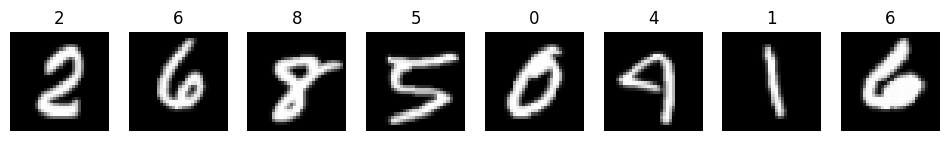

In [3]:
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    img = denormalize(images[i]).squeeze(0)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{labels[i].item()}")
    ax.axis("off")

plt.show()

In [4]:

import torch.nn as nn


class Generator(nn.Module):

    """
    Generador MLP estilo Goodfellow (2014) para imágenes 1x32x32 (1024 pixeles).
    - Entrada: z ~ N(0, I), dim=latent_dim
    - Capas ocultas: FC + (BatchNorm1d opcional) + ReLU
    - Salida: FC -> Tanh, reshape a (B, 1, 32, 32)
    """

    def __init__(self, latent_dim = 100, img_channels = 1, img_size = 32,
                 hidden_dims=(256, 512, 1024) , batch_norm=True):

        super().__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels
        self.img_size = img_size
        self.out_dim = img_channels * img_size * img_size

        layers = []
        in_dim = latent_dim

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h, bias=True))

            if batch_norm:
                layers.append(nn.BatchNorm1d(h))

            layers.append(nn.ReLU(inplace=True))
            in_dim = h

        layers.append(nn.Linear(in_dim, self.out_dim))
        layers.append(nn.Tanh())

        self.net = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor):
        """
        z: (B, latent_dim)
        return: (B, 1, 32, 32) en [-1, 1]
        """

        x = self.net(z)
        # Re acomodar el vector en forma de imagen (batch , 1×32×32)
        x = x.view(z.size(0), self.img_channels, self.img_size, self.img_size)
        return x

    @torch.no_grad()
    def sample(self, n: int):
        """
        Usado para testear despues de entrenar.
        """
        z = torch.randn(n, self.latent_dim)
        return self.forward(z)

In [5]:
class Discriminator(nn.Module):
    """
    Discriminador MLP para imágenes 1x32x32.
    Salida: logits (B, 1) -> usar con BCEWithLogitsLoss
    """

    def __init__(self, img_channels = 1, img_size= 32,
                 hidden_dims=(1024, 512, 256), dropout_p = 0.3 , batch_norm = True):

        super().__init__()
        self.img_channels = img_channels
        self.img_size = img_size
        in_dim = img_channels * img_size * img_size  # 1*32*32 = 1024

        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h, bias=True))

            if batch_norm:
                layers.append(nn.BatchNorm1d(h))

            layers.append(nn.LeakyReLU(0.2, inplace=True))

            if dropout_p > 0:
                layers.append(nn.Dropout(dropout_p))

            prev = h

        layers += [nn.Linear(prev, 1), nn.Sigmoid()]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: (B, 1, 32, 32) en [-1, 1]
        return: logits (B, 1)
        """
        b = x.size(0)
        x = x.view(b, -1)
        probs = self.net(x)
        return probs

def weights_init_normal(m):
    """
    Inicialización tipo DCGAN (funciona bien también para MLPs):
    - Linear: N(0, 0.02), bias = 0
    - BatchNorm: gamma ~ N(1,0.02), beta = 0
    """

    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)

        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)



In [17]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generador = Generator(latent_dim=100, img_channels=1, img_size=32, batch_norm=True).to(device)
discrimiador = Discriminator(img_channels=1, img_size=32, batch_norm=False).to(device)


generador.apply(weights_init_normal)
discrimiador.apply(weights_init_normal)

criterion = nn.BCELoss()
optimizerGen = optim.Adam(generador.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerDisc = optim.Adam(discrimiador.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [15]:
import torchvision.utils as vutils
import os

def train_gan(train_loader, generador, discriminador,
    optimizerG, optimizerD, criterion,
    latent_dim = 100, epochs = 20, sample_every = 1,
    fixed_z = None , smooth = False , smooth_advance = False):

    """
    Entrena una GAN : D con Sigmoid + BCELoss; G con pérdida no-saturante.

    Retorna: diccionario con histórico de pérdidas por epoch: {'loss_D': [...], 'loss_G': [...]}
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generador.to(device)
    discriminador.to(device)

    if smooth == True and smooth_advance == True:
        raise ValueError(f'No se puede tener dos suavizamientos al tiempo')

    # Vector de ruido fijo para ver progreso consistente a través de epochs
    if fixed_z is None:
        os.makedirs("samples", exist_ok=True)
        fixed_z = torch.randn(64, latent_dim, device=device)

        with torch.no_grad():
          fake_imgs_init = generador(fixed_z).detach()

        path = f"samples/epoch_init.png"
        vutils.save_image(fake_imgs_init, path, normalize=True, nrow=8)

        grid = vutils.make_grid(fake_imgs_init, normalize=True, nrow=8)
        grid_cpu = grid.detach().cpu()
        plt.figure(figsize=(6,6))
        plt.axis("off")
        plt.title(f"Fake samples (init)")
        plt.imshow(grid_cpu.permute(1, 2, 0).numpy())
        plt.show()
    else:
        fixed_z = fixed_z.to(device)


    history = {'loss_D': [], 'loss_G': []}

    generador.train()
    discriminador.train()

    for epoch in range(1, epochs + 1):
        running_D, running_G, n_batches = 0.0, 0.0, 0

        for real, _ in train_loader:
            b = real.size(0)
            real = real.to(device, non_blocking=True)
            # Etiquetas: 1 para reales, 0 para falsas


            if smooth:
                real_labels = torch.full((b, 1), 0.9 , device=device)
            elif smooth_advance:
                real_labels = torch.empty(b, 1, device=device).uniform_(0.8, 1.0) # en vez de todos exactamente 0.9, los hacemos variar entre 0.8 y 1.0
            else:
                real_labels = torch.ones(b, 1, device=device)

            fake_labels = torch.zeros(b, 1, device=device)

            # =====================================
            # (1) Update D: max log D(x) + log(1 - D(G(z))) =  O sea verdaderas como verdaderas, falsas como falsas

            # En la practica queremos que su loss sea 0.69 (−log 0.5)
            # Para un G fijo D si logra maximizar (una iteracion), cuando G cambia: D se deberia volver mas ineficiente.
            # Al final el discriminador se vuelve igual que lanzar una moneda 50/50
            # =====================================
            optimizerD.zero_grad(set_to_none=True)

            # Reales: D(x) debe acercarse a 1
            out_real = discriminador(real)           # Probabilidades debido a sigmoid
            loss_D_real = criterion(out_real, real_labels) # −log D(real).

            # Falsas: G(z) -> detach para NO actualizar G en el paso de D
            z = torch.randn(b, latent_dim , device=device)
            fake = generador(z).detach()                      # rompe gradiente hacia G
            out_fake = discriminador(fake)                    # D(G(z)) debe acercarse a 0 para maximizar
            loss_D_fake = criterion(out_fake, fake_labels)    # −log (1 − D(G(z)))

            # Promediamos pérdidas real/fake para estabilidad
            loss_D = 0.5 * (loss_D_real + loss_D_fake)
            loss_D.backward() # Actualizamos solo D
            optimizerD.step()

            # =====================================
            # (2) Update G:  min log(1 - D(G(z)))  ≡  max log D(G(z)) o sea confundir al discriminador

            # Aca lo importante es notar que ambas cosas no pueden maximizarse a la misma vez son contrarias.
            # =====================================
            optimizerG.zero_grad(set_to_none=True)

            z = torch.randn(b, latent_dim , device=device)
            fake = generador(z)                               # ahora SÍ queremos gradiente hacia G
            out_fake_for_G = discriminador(fake)

            # G quiere que D "piense" que estas falsas son reales (target=1)
            loss_G = criterion(out_fake_for_G, real_labels) # Perdida no saturante

            loss_G.backward() #  retropropaga el gradiente a través de D (porque lo usamos para las probs) pero solo actualiza G
            optimizerG.step()


            # Acumular métricas
            running_D += loss_D.item()
            running_G += loss_G.item()
            n_batches += 1

        epoch_loss_D = running_D / max(n_batches, 1)
        epoch_loss_G = running_G / max(n_batches, 1)
        history['loss_D'].append(epoch_loss_D)
        history['loss_G'].append(epoch_loss_G)


        if (sample_every is not None) and ((epoch + 1) % 5 == 0):
            print(f"[Epoch {epoch:03d}/{epochs}]  loss_D={epoch_loss_D:.4f} | loss_G={epoch_loss_G:.4f}")

        if (sample_every is not None) and ((epoch + 1) % 10 == 0):

            with torch.no_grad():
                fake_imgs = generador(fixed_z).detach()

            path = f"samples/epoch_{epoch+1:04d}.png"
            vutils.save_image(fake_imgs, path, normalize=True, nrow=8)

            grid = vutils.make_grid(fake_imgs, normalize=True, nrow=8)
            grid_cpu = grid.detach().cpu()
            plt.figure(figsize=(6,6))
            plt.axis("off")
            plt.title(f"Fake samples (epoch {epoch+1})")
            plt.imshow(grid_cpu.permute(1, 2, 0).numpy())
            plt.show()


    return history

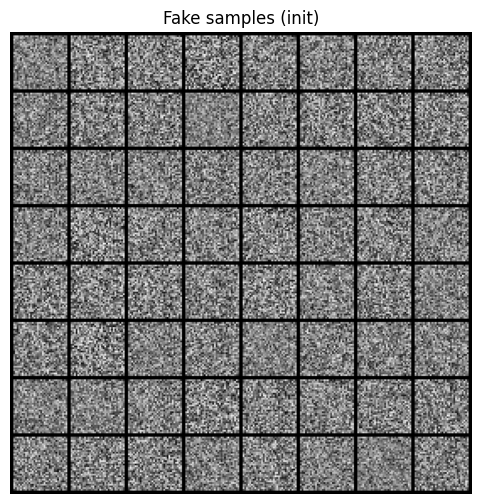

[Epoch 004/100]  loss_D=0.6393 | loss_G=0.9118
[Epoch 009/100]  loss_D=0.6801 | loss_G=0.7625


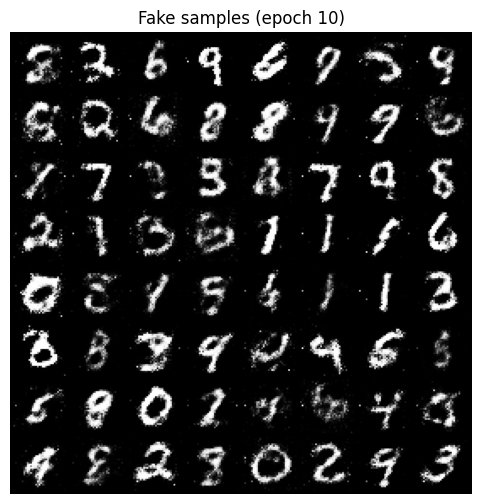

[Epoch 014/100]  loss_D=0.6906 | loss_G=0.7173
[Epoch 019/100]  loss_D=0.6923 | loss_G=0.7045


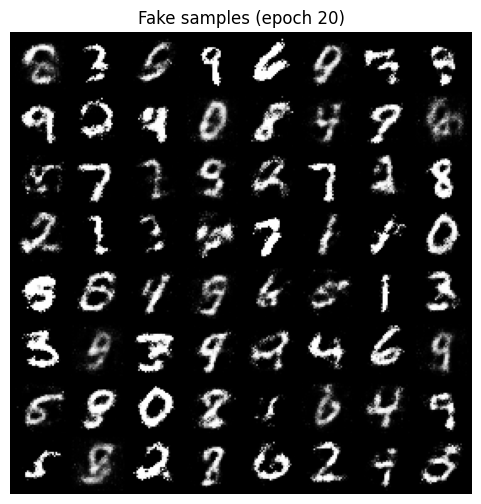

[Epoch 024/100]  loss_D=0.6915 | loss_G=0.7086
[Epoch 029/100]  loss_D=0.6905 | loss_G=0.7115


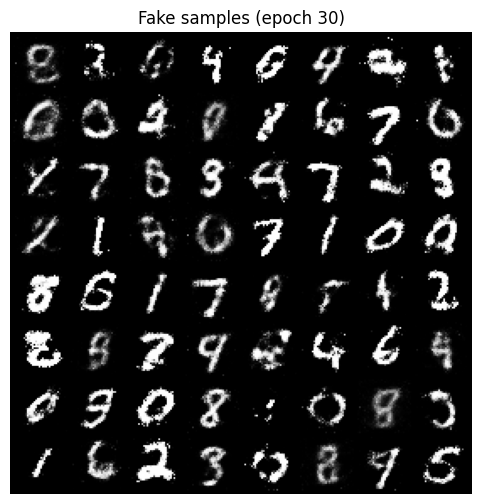

[Epoch 034/100]  loss_D=0.6903 | loss_G=0.7126
[Epoch 039/100]  loss_D=0.6903 | loss_G=0.7114


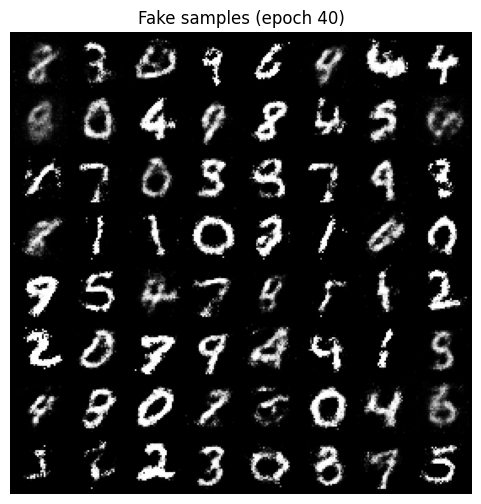

[Epoch 044/100]  loss_D=0.6892 | loss_G=0.7149
[Epoch 049/100]  loss_D=0.6877 | loss_G=0.7205


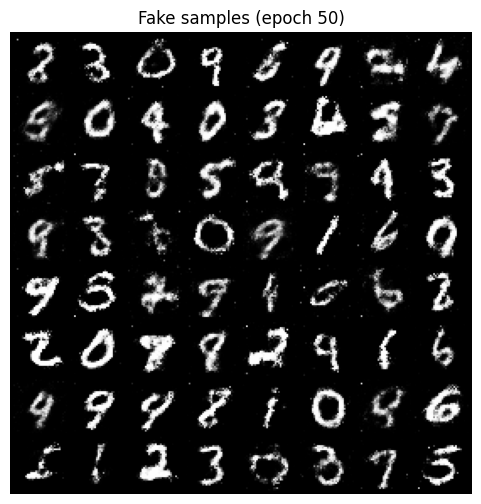

[Epoch 054/100]  loss_D=0.6813 | loss_G=0.7439
[Epoch 059/100]  loss_D=0.6637 | loss_G=0.8044


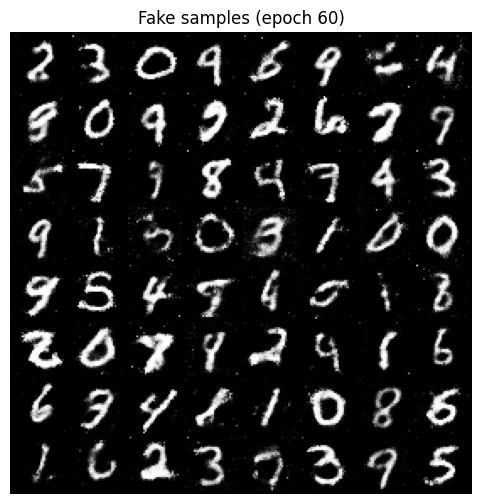

[Epoch 064/100]  loss_D=0.6430 | loss_G=0.8880
[Epoch 069/100]  loss_D=0.6239 | loss_G=0.9617


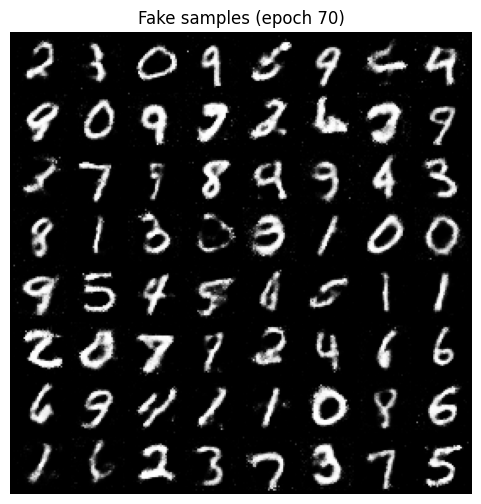

[Epoch 074/100]  loss_D=0.6095 | loss_G=1.0356
[Epoch 079/100]  loss_D=0.5898 | loss_G=1.1206


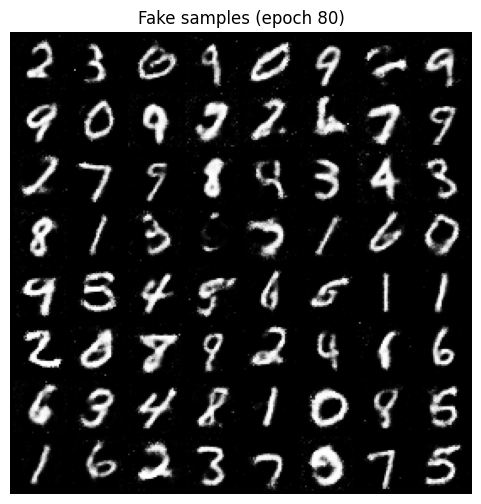

[Epoch 084/100]  loss_D=0.5731 | loss_G=1.1973
[Epoch 089/100]  loss_D=0.5511 | loss_G=1.3187


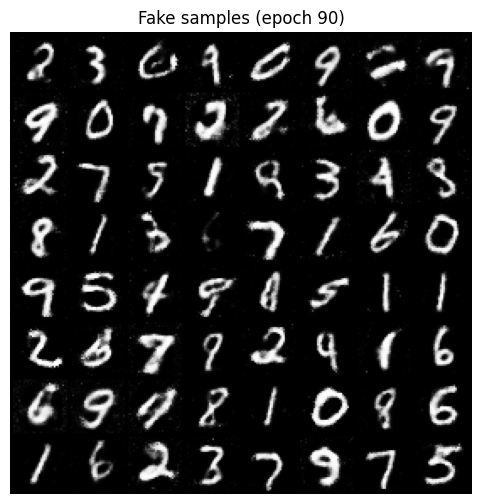

[Epoch 094/100]  loss_D=0.5353 | loss_G=1.3968
[Epoch 099/100]  loss_D=0.5222 | loss_G=1.4776


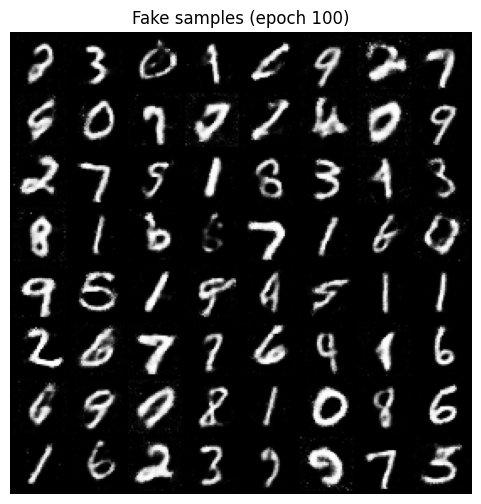

In [18]:

history = train_gan( train_loader=train_loader,
    generador=generador, discriminador=discrimiador, optimizerG=optimizerGen, optimizerD=optimizerDisc,
    criterion=criterion,
    latent_dim=100, epochs=100, sample_every=1)


## Evaluation of the model

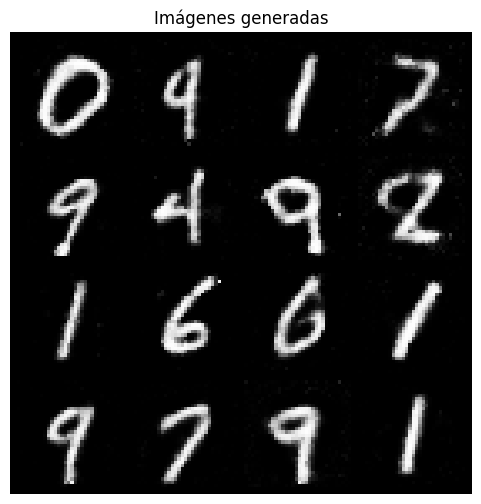

In [20]:

z = torch.randn(16, 100, device=device)

generador.eval()
with torch.no_grad():
  fake_imgs = generador(z).detach().cpu()

grid = vutils.make_grid(fake_imgs, normalize=True, nrow=4)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Imágenes generadas")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()